# Titanic Survival Prediction

This notebook contains the model development for predicting survival on the Titanic dataset.

In [5]:
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report
import joblib
import warnings
import os
warnings.filterwarnings('ignore')

## Data Loading and Exploration

In [6]:
# Load the dataset from local file
df = pd.read_csv('../data/titanic.csv')

# Display basic information
print("Dataset Shape:", df.shape)
print("\nMissing Values:")
print(df.isnull().sum())

# Display first few rows
df.head()

Dataset Shape: (891, 12)

Missing Values:
PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


## Feature Engineering

In [7]:
def engineer_features(df):
    # Create a copy to avoid modifying the original dataframe
    df = df.copy()
    
    # Extract titles from names
    df['Title'] = df['Name'].str.extract(' ([A-Za-z]+)\.', expand=False)
    
    # Create family size feature
    df['FamilySize'] = df['SibSp'] + df['Parch'] + 1
    
    # Create fare bins
    df['FareBin'] = pd.qcut(df['Fare'], 4, labels=['Low', 'Mid', 'Mid-High', 'High'])
    
    # Create age bins
    df['AgeBin'] = pd.qcut(df['Age'], 4, labels=['Young', 'Adult', 'Middle', 'Senior'])
    
    # Fill missing values
    df['Age'].fillna(df['Age'].median(), inplace=True)
    df['Embarked'].fillna(df['Embarked'].mode()[0], inplace=True)
    
    # Convert categorical variables
    df = pd.get_dummies(df, columns=['Sex', 'Embarked', 'Title', 'FareBin', 'AgeBin'])
    
    return df

# Apply feature engineering
df_engineered = engineer_features(df)
df_engineered.head()

,PassengerId,Survived,Pclass,Name,Age,SibSp,Parch,Ticket,Fare,Cabin,...,Title_Rev,Title_Sir,FareBin_Low,FareBin_Mid,FareBin_Mid-High,FareBin_High,AgeBin_Young,AgeBin_Adult,AgeBin_Middle,AgeBin_Senior
0,1,0,3,"Braund, Mr. Owen Harris",22.0,1,0,A/5 21171,7.2500,NaN,...,False,False,True,False,False,False,False,True,False,False
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",38.0,1,0,PC 17599,71.2833,C85,...,False,False,False,False,False,True,False,False,True,False
2,3,1,3,"Heikkinen, Miss. Laina",26.0,0,0,STON/O2. 3101282,7.9250,NaN,...,False,False,False,True,False,False,False,True,False,False
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",35.0,1,0,113803,53.1000,C123,...,False,False,False,False,False,True,False,False,True,False
4,5,0,3,"Allen, Mr. William Henry",35.0,0,0,373450,8.0500,NaN,...,False,False,False,True,False,False,False,False,True,False


## Model Training and Evaluation

Random Forest Model Performance:
Accuracy: 0.8268156424581006

Classification Report:
              precision    recall  f1-score   support

           0       0.85      0.86      0.85       105
           1       0.79      0.78      0.79        74

    accuracy                           0.83       179
   macro avg       0.82      0.82      0.82       179
weighted avg       0.83      0.83      0.83       179



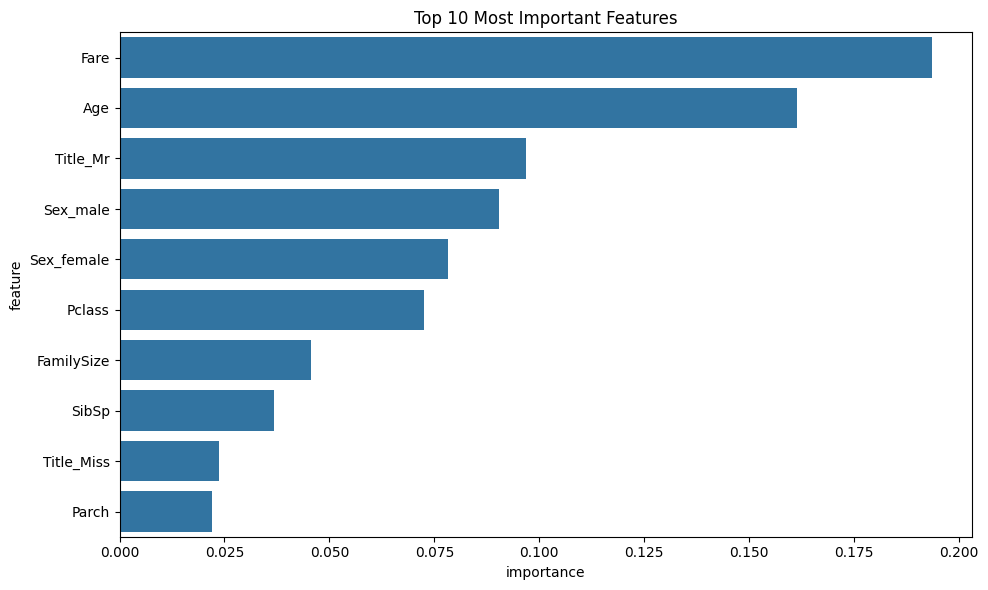

In [8]:
# Prepare features and target
features = ['Pclass', 'Age', 'SibSp', 'Parch', 'Fare', 'FamilySize'] + \
           [col for col in df_engineered.columns if col.startswith(('Sex_', 'Embarked_', 'Title_', 'FareBin_', 'AgeBin_'))]
X = df_engineered[features]
y = df_engineered['Survived']

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Train Random Forest model
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train_scaled, y_train)

# Make predictions
y_pred = rf_model.predict(X_test_scaled)

# Print results
print("Random Forest Model Performance:")
print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# Create model directory if it doesn't exist
os.makedirs('../model', exist_ok=True)

# Save the model and scaler
joblib.dump(rf_model, '../model/rf_model.pkl')
joblib.dump(scaler, '../model/scaler.pkl')

# Plot feature importance
plt.figure(figsize=(10, 6))
feature_importance = pd.DataFrame({
    'feature': features,
    'importance': rf_model.feature_importances_
})
feature_importance = feature_importance.sort_values('importance', ascending=False)
sns.barplot(x='importance', y='feature', data=feature_importance.head(10))
plt.title('Top 10 Most Important Features')
plt.tight_layout()
plt.show()